## Generate data
This notebook generates the source text (20 newsgroup email bodies), data (high dimension vectors), and labels (newsgroup topic) to use for TSNE, and to visualise in the app. 

We will represent 20 newsgroup email bodies as vectors with three different methods or 'embeddings':
- TFIDF (and SVD)
- Doc2Vec
- Mean of BERT word vectors

Generate data and labels are stored in the 'data/' folder.  Once generated, you can use 'generate_tsne_vectors.py' to generate the lower dimension vectors for each embedding.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import csv
import re
from pprint import pprint
from collections import Counter

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using 20 Newsgroup dataset, I **filter down to 5 relatively distinct categories for easier visualisation.** 

In [8]:
from sklearn.datasets import fetch_20newsgroups

# remove headers and footers (quotes left in for now)
newsgroups_train = fetch_20newsgroups(subset='train',  remove=('headers', 'footers'))

target_names = ['comp.graphics', 'rec.sport.baseball', 'talk.politics.mideast', 'rec.autos', 'sci.med']
target_nums = [i for i in range(20) if newsgroups_train.target_names[i] in target_names]

masks = [newsgroups_train.target == i for i in target_nums]
mask = np.array([any(tup) for tup in zip(*masks)])

data = np.array(newsgroups_train.data)[mask]
targets = np.array(newsgroups_train.target)[mask]

print(f'Counts\n\ndata shape: {data.shape}')
print(f'targets shape: {targets.shape}\n')

for name, count in zip(target_names, [np.sum(m) for m in masks]):
    print(f'{name}: {count}')

Counts

data shape: (2933,)
targets shape: (2933,)

comp.graphics: 584
rec.sport.baseball: 594
talk.politics.mideast: 597
rec.autos: 594
sci.med: 564


Save out the **source text as pickle dataframe for the app to display**

In [9]:
text = pd.DataFrame(data)
text.to_pickle('data/source_text.pkl')

### 1) TFIDF (and SVD)
We'll first use TFIDF to create a high dimension representation of each email.  We'll then use SVD to reduce dimensions to 200, as running TSNE on 60K+ dimension vectors isn't a great use of time.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# vectorize
bow_vec = TfidfVectorizer(max_df=0.25, min_df=0.001, ngram_range=(1, 2),
                          sublinear_tf=True, use_idf=True)
%time doc_bow = bow_vec.fit_transform(data)

# get vocab
vocab = bow_vec.get_feature_names()
print('\nVocab size:', len(vocab))
print('Document vector shape:', doc_bow.shape)

CPU times: user 2.77 s, sys: 74.8 ms, total: 2.85 s
Wall time: 2.67 s

Vocab size: 60109
Document vector shape: (2933, 60109)


**Most frequent words** (including bigrams)

In [11]:
counts = np.count_nonzero(doc_bow.toarray(), axis=0)
percentage = 100 * counts / len(data)
print('Token'.ljust(10), '% Docs', sep='\t')
print('='*30)
for idx in np.argsort(counts)[-25:]:
    print(vocab[idx].ljust(10), f'{percentage[idx]:.2f}', sep='\t')

Token     	% Docs
these     	19.16
that the  	19.77
could     	19.98
for the   	20.08
time      	20.12
them      	20.76
people    	21.00
had       	21.41
does      	21.55
than      	21.79
com       	21.79
we        	21.85
to be     	22.37
were      	22.74
their     	22.81
also      	23.05
he        	23.18
only      	23.32
get       	23.59
other     	23.63
how       	23.66
been      	23.66
when      	23.90
think     	24.21
it is     	24.96


We use SVD to reduce dimensions, and while it doesn't explain a lot of variance, it's interesting that TSNE is still able to (relatively) clearly seperate by class.

In [12]:
# https://scikit-learn.org/stable/modules/decomposition.html
from sklearn.decomposition import TruncatedSVD, PCA
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
%time doc_bow_svd = svd.fit_transform(doc_bow) 

print('explained variance:', svd.explained_variance_ratio_.sum())

CPU times: user 14.4 s, sys: 532 ms, total: 14.9 s
Wall time: 5.1 s
explained variance: 0.2412403650901674


Some helper functions to save out files and labels

In [25]:
def save_vectors(vectors, name:string):
    PATH = f"data/{name}_input.csv"
    # create .csv header
    head_vals = np.arange(vectors.shape[1])
    header = ",".join([item for item in head_vals.astype(str)])
    np.savetxt(PATH, vectors, header=header, comments='', delimiter=',')
    print(f'Saved in {PATH}')

    
def save_labels(name:string):
    PATH = f'data/{name}_labels.csv'
    # first row is header
    labels = ['header'] + [newsgroups_train.target_names[i] for i in targets]
    with open(PATH, 'w') as myfile:
        wr = csv.writer(myfile,dialect='excel')
        for row in labels:
            wr.writerow([row])
    print(f'Saved in {PATH}')
    
save_labels('tfidf')
save_vectors(doc_bow_svd, 'tfidf')

Saved in data/tfidf_input.csv


**Baseline check: Is PCA good enough?**  
Plot first 2 PCA dimensions to see whether more effort is justified on dimensionality reduction / visualation. 

In [13]:
from sklearn.decomposition import PCA

pca_vectors = PCA(n_components=2).fit_transform(doc_bow_svd)

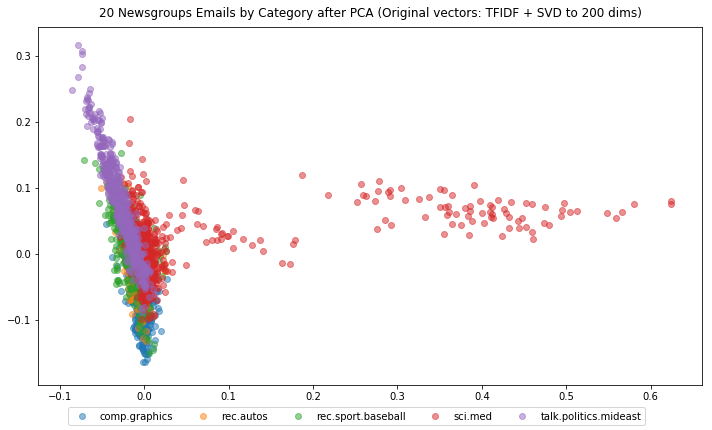

In [36]:
def PCA_plot(X_2d, labels, subtitle=''):
    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    plt.title(f'20 Newsgroups Emails by Category after PCA {subtitle}',pad=10)
    for i in np.unique(labels):
        axes.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], \
                    alpha=0.5, label=newsgroups_train.target_names[i])
        # only get labels from last run
        handles, legend_label = axes.get_legend_handles_labels()
    fig.legend(handles, legend_label, loc='lower center', ncol=5)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1)
    plt.show()

PCA_plot(pca_vectors, targets,subtitle='(Original vectors: TFIDF + SVD to 200 dims)')

### 2) Doc2Vec

For the next iteration, we'll switch from bag of words / count based vector representations to learned word embeddings. The simplest path is using pre-generated word vectors (e.g. Glove) and take an average of all word vectors to represent a document. Doc2Vec is a slightly more complex method that trains a seperate document vector apart from individual word vectors. See more below for the gensim implementation:

https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb

In [30]:
import gensim

# tokenize
def read_corpus(data, tokens_only=False):
    for i, doc in enumerate(data):
        if tokens_only:
            yield gensim.utils.simple_preprocess(doc)
        else:
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(doc), [i])
        
corpus = list(read_corpus(data))

/Users/nus/miniconda3/envs/tsne-vis-env/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


We'll generate 200 dimension vectors for each document

In [31]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=200, min_count=2, epochs=40)
model.build_vocab(corpus)

print(f'Vocab length: {len(model.wv.vocab)}\n')
print(f'Sample tokenised doc:\n{corpus[0]}')

vocab length: 20979

sample tokenised doc:
TaggedDocument(['was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail'], [0])


In [32]:
%time model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)


CPU times: user 59.4 s, sys: 1.36 s, total: 1min
Wall time: 24.1 s


The Gensim implementation has the ability to infer vectors for new documents (so you don't have to retrain on every new document).  However I've found in practice the inferred vectors are far less useful than trained vectors, so I'll skip over that (time isn't a constraint here).

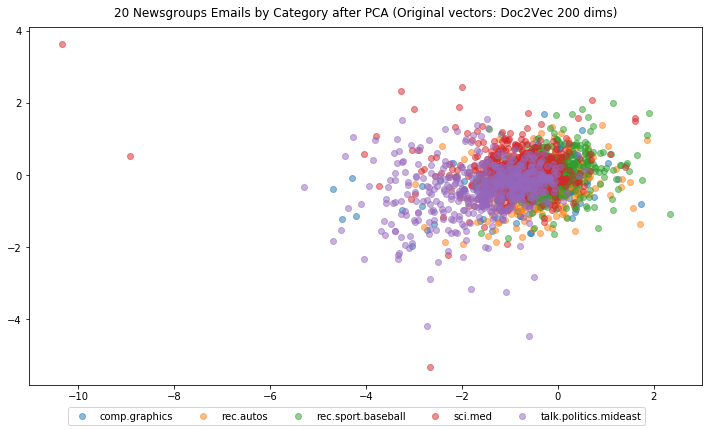

In [37]:
PCA_plot(model.docvecs.vectors_docs, targets,subtitle='(Original vectors: Doc2Vec 200 dims)')

Again, PCA doesn't seem to capture much of the variation by category.

In [28]:
save_vectors(model.docvecs.vectors_docs, 'doc2vec')
save_labels('doc2vec')

Saved in data/doc2vec_input.csv
Saved in data/doc2vec_labels.csv


### BERT

https://github.com/hanxiao/bert-as-service

In [62]:
bert_text = list(text.strip() for text in data)
bert_text = ['BLANK' if text is '' else text for text in bert_text]

In [73]:
from bert_serving.client import BertClient

# start server e.g.
# bert-serving-start -model_dir ~/models/BERT/cased_L-12_H-768_A-12/ -num_worker=4 -max_seq_len=500

bc = BertClient(ip='137.117.67.76', show_server_config=True)
%time bert_vectors = bc.encode(bert_text)

server config:
                        client	=	4d940469-5918-4f4d-8a1c-b068b8938f87
                   num_process	=	2                             
          ventilator -> worker	=	['ipc://tmpRytRC8/socket', 'ipc://tmpORskFY/socket', 'ipc://tmpZc9NHO/socket', 'ipc://tmp2RmiKE/socket', 'ipc://tmpmZaNMu/socket', 'ipc://tmpmaiiPk/socket', 'ipc://tmpfsXNRa/socket', 'ipc://tmp4t9jU0/socket']
                worker -> sink	=	ipc://tmpSpUOnf/socket        
           ventilator <-> sink	=	ipc://tmpq32oAi/socket        
           server_current_time	=	2019-04-25 10:12:00.033451    
                     statistic	=	{'num_data_request': 0, 'num_total_seq': 0, 'num_sys_request': 1, 'num_total_request': 1, 'num_total_client': 1, 'num_active_client': 0, 'avg_request_per_client': 1.0, 'min_request_per_client': 1, 'max_request_per_client': 1, 'num_min_request_per_client': 1, 'num_max_request_per_client': 1}
                    device_map	=	[]                            
         num_concurrent_sock

/Users/nus/miniconda3/envs/tsne-vis-env/lib/python3.6/site-packages/bert_serving/client/__init__.py:286: UserWarning: some of your sentences have more tokens than "max_seq_len=250" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


CPU times: user 101 ms, sys: 190 ms, total: 291 ms
Wall time: 39 s


In [75]:
save_vectors(bert_vectors, 'bert_250_word_mean')
save_labels('bert_250_word_mean')

Saved in data/bert_250_word_mean_input.csv
Saved in data/bert_250_word_mean_labels.csv


### Try out new tsne

In [35]:
import bhtsne

%time output = bhtsne.tsne(doc_bow_svd, dimensions=3)

CPU times: user 1min 15s, sys: 3.08 s, total: 1min 18s
Wall time: 1min 18s


In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
%time output_2 = tsne.fit_transform(doc_bow_svd)

CPU times: user 2min 31s, sys: 5.3 s, total: 2min 36s
Wall time: 2min 36s
